# 2. Linear Elasticity-Perfect Plasticity

This example can be found in Section 5.3 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

## 1. Experimental observations

![](figures/linear-elastic-perfectly-plastic-experimental-observations.png)

## 2. Material model

In [2]:
def compute_stress(E, stress_y, strains):
    """
    Linear elastic-perfectly plastic material
    """
    stress = []
    strain_y = stress_y / E

    for strain in strains:
        if strain <= strain_y:
            stress.append(E * strain)
        else:
            stress.append(stress_y)

    return stress

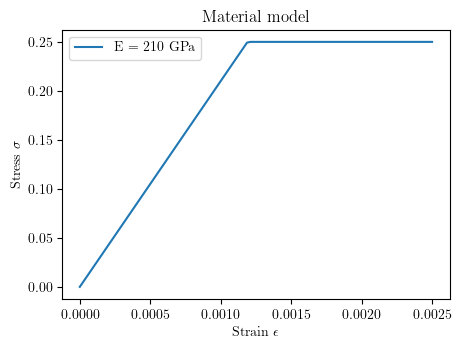

In [3]:
E = 210
stress_y = 0.25
strain = np.linspace(0, 2.5e-3, 100)
stress = compute_stress(E, stress_y, strain)

plt.figure(figsize=(5, 3.5))
plt.plot(strain, stress, label=f"E = {E} GPa")
plt.title("Material model")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()
plt.savefig("figures/linear-elastic-perfectly-plastic-material-model.png", dpi=300)

In [4]:
class BaseModel:
    """
    Base class for models used in Bayesian inference.

    Subclasses must implement the __call__ method.
    """

    def __call__(self, *args, **kwargs):
        """
        Define the behaviour of the model.

        Parameters
        ----------
        *args : tuple
            Positional arguments.

        **kwargs : dict
            Keyword arguments.

        Returns
        -------
        Any
            The output of the model.
        """
        raise NotImplementedError("Subclasses must implement __call__ method.")


class LinearElasticPerfectlyPlastic(BaseModel):
    """
    Linear elastic-perfectly plastic material

    Attributes:
    -----------
    x_observed : float
        The observed value of the independent variables.
    """

    def __init__(self, x_observed):
        """
        Parameters
        ----------
        x_observed : float
            The observed value of the independent variables.
        """
        self.x_observed = x_observed

    def __call__(self, parameters):
        """
        Compute stress based on the provided parameters.

        Parameters
        ----------
        parameters : tuple or list
            Model parameters. For a linear elastic-perfectly plastic model, it should
            contain two parameters representing the Young's Modulus and Yield Stress.

        Returns
        -------
        stress : float
            Computed stress.
        """
        if len(parameters) != 2:
            raise ValueError(
                "LinearElasticPerfectlyPlastic model expects two parameters."
            )

        E = parameters[0]
        stress_y = parameters[1]

        stress = []
        strain_y = stress_y / E

        for strain in self.x_observed:
            if strain <= strain_y:
                stress.append(E * strain)
            else:
                stress.append(stress_y)

        return stress

## 3. Genererating synthetic data

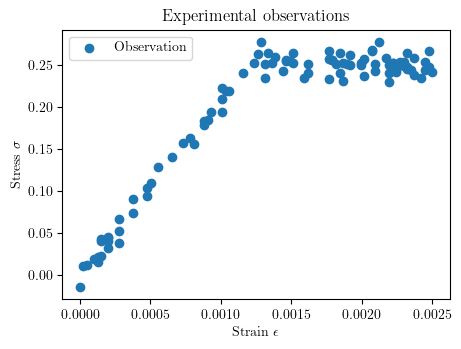

In [5]:
sigma = 0.01  # standard deviation of the noise
n_observations = 100
x = np.linspace(0, 2.5e-3, 100)
strain_observed = np.random.choice(x, n_observations)
stress_observed = compute_stress(E, stress_y, strain_observed) + np.random.normal(
    scale=sigma, size=strain_observed.shape[0]
)

plt.figure(figsize=(5, 3.5))
plt.scatter(strain_observed, stress_observed, label="Observation")
plt.title("Experimental observations")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()
# plt.savefig("figures/linear-elastic-perfectly-plastic-experimental-observations.png", dpi=300)

## 4. Prior

In [6]:
class Prior:

    def __init__(self, mean=np.array([0, 0]), std_dev=np.array([1, 1])):
        """
        Initialise the multivariate normal prior distribution.

        Parameters
        ----------
        mean : array-like, optional
            Mean vector of the multivariate normal distribution. Default is np.array([0, 0]).

        std_dev : array-like
            Standard deviation vector of the multivariate normal distribution. Default is np.array([1, 1]).
        """
        self.mean = np.array(mean)
        self.std_dev = np.array(std_dev)
        self.cov = np.diag(self.std_dev**2)

    def evaluate(self, x):
        """
        Evaluate the prior function at the given value(s) of x.

        Parameters
        ----------
        x : array-like
            The value(s) at which to evaluate the prior function.

        Returns
        -------
        array-like
            The prior probability density at the given value(s).
        """
        return scipy.stats.multivariate_normal.pdf(x, mean=self.mean, cov=self.cov)

    def plot(self, x_values):
        """
        Plot the prior function over a range of x values.

        Parameters
        ----------
        x_values : array-like
            The range of x values for plotting.
        """
        prior_values = self.evaluate(x_values)
        # plt.contourf()

## 5. Likelihood

In [7]:
class Likelihood:

    def __init__(self, y, sigma, model):
        """
        y : ndarray
            Observed data
        """
        self.y = y
        self.sigma = sigma
        self.model = model

    def evaluate(self, x):
        """
        x : float or array-like
            The value(s) of the model parameters.
        """
        residual = self._compute_residual(x)
        return (
            1
            / (self.sigma * np.sqrt(2 * np.pi))
            * np.exp(-0.5 * (residual / self.sigma**2))
        )

    def _compute_residual(self, x):
        return np.sum((self.y - self.model(x))**2)

## 6. Posterior

In [8]:
class Posterior:

    def __init__(self, prior, likelihood):
        self.prior = prior
        self.likelihood = likelihood

    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.prior.evaluate(x) * self.likelihood.evaluate(x)

In [9]:
class LogPosterior:

    def __init__(self, prior, likelihood):
        self.prior = prior
        self.likelihood = likelihood

    def evaluate(self, x):
        """
        Compute the log posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The logarithm of the posterior probability distribution for the given model parameters.
        """
        return np.log(self.prior.evaluate(x)) + np.log(self.likelihood.evaluate(x))

In [10]:
model = LinearElasticPerfectlyPlastic(strain_observed)
prior = Prior(mean=np.array([200, 0.29]), std_dev=np.array([25, 0.015]))
likelihood = Likelihood(stress_observed, sigma, model)
posterior = Posterior(prior, likelihood)

## 7. Optimisation



In [11]:
class GradientDescent:
    
    def __init__(self, model, observed, initial_candidate):
        self.model = model
        self.observed = observed
        self.candidate = initial_candidate

    def optimise(self, step_size, n_steps=100):
        """
        Optimise the cost function using gradient descent.

        Parameters:
        step_size (float): Learning rate for the gradient descent.
        n_steps (int): Number of iterations for the gradient descent.

        Returns:
        """
        cost_hist = []
        candidate_hist = []
        
        for _ in range(n_steps):
            gradient = self._compute_gradient()
            self.candidate -= step_size * gradient
            candidate_hist.append(np.copy(self.candidate))
            cost_hist.append(self._cost_function(self.candidate))
        
        return np.array(candidate_hist), cost_hist
        
    def _compute_gradient(self, h=1e-5):
        """
        Employ the finite difference method to compute the gradient of the 
        cost function with respect to the model parameters.

        Parameters:
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)
        
        for i in range(len(x)):
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (self._cost_function(x_forward) - self._cost_function(x_backward)) / (2 * h)
        
        return gradient

    def _cost_function(self, candidate):
        return np.mean((self.observed - model(candidate))**2)

In [12]:
initial_params = np.array([220, 0.29])
optimiser = GradientDescent(model, stress_observed, initial_params)
candidate_hist, cost_hist = optimiser.optimise(step_size=np.array([10, 0.1]), n_steps=100000)

print("Optimised Parameters:", candidate_hist[-1])
print("Final Error:", cost_hist[-1])

Optimised Parameters: [217.01789762   0.25067296]
Final Error: 0.00010787050037120535


### 7.1 Plot the cost history

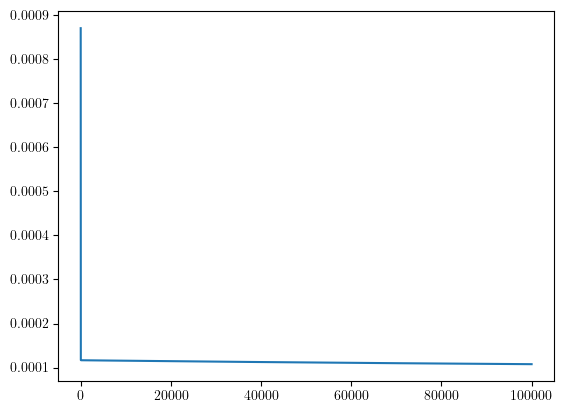

In [13]:
plt.plot(cost_hist)

### 7.2 Plot the cost surface

In [14]:
def plot_cost_contour(param1_range, param2_range, cost_function, candidate_hist):
    """
    Plot the cost function contour for two parameters varying within specified ranges.
    
    Parameters:
    param1_range (np.ndarray): Range of values for the first parameter.
    param2_range (np.ndarray): Range of values for the second parameter.
    cost_function (callable): Function that computes the cost given a list of parameter values.
    """
    param1_grid, param2_grid = np.meshgrid(param1_range, param2_range)
    cost_surface = np.vectorize(lambda p1, p2: cost_function([p1, p2]))(param1_grid, param2_grid)
    
    plt.figure()
    contour = plt.contour(param1_grid, param2_grid, cost_surface, cmap='viridis', levels=50)
    plt.scatter(candidate_hist[:, 0], candidate_hist[:, 1])
    plt.xlabel('E')
    plt.ylabel('Yield stress')
    plt.title('Cost function contour plot')
    plt.show()

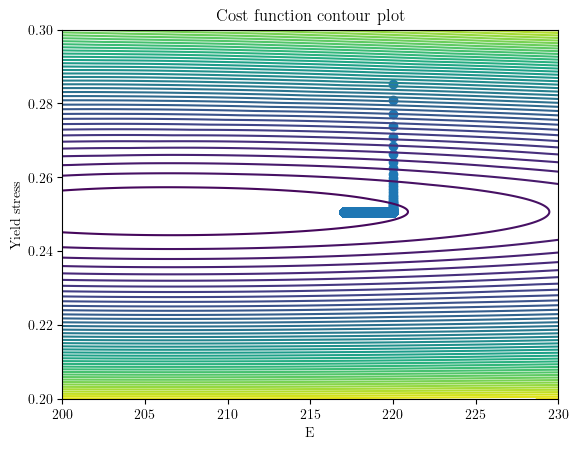

In [15]:
plot_cost_contour(np.linspace(200, 230, 1000), np.linspace(0.2, 0.3, 1000), optimiser._cost_function, candidate_hist)

## 8. Standard Metropolis Hastings

In [16]:
def mh_sampler(posterior, steps=3000, step_size=5, init=0):
    """
    Metropolis-Hastings sampler with a normal proposal
    """
    point = init
    samples = []
    pdf = []
    for _ in range(int(steps)):
        proposal = np.random.normal(point, step_size)
        if np.random.rand() < posterior.evaluate(proposal) / posterior.evaluate(point):
            point = proposal
        samples.append(point)
        pdf.append(posterior.evaluate(point))
    return np.array(samples), np.array(pdf)

In [17]:
samples, pdf = mh_sampler(
    posterior, steps=1e5, step_size=np.array([2.5, 0.05]), init=np.array([150, 0.15])
)

/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_78354/330765538.py:10: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < posterior.evaluate(proposal) / posterior.evaluate(point):
/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_78354/330765538.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  if np.random.rand() < posterior.evaluate(proposal) / posterior.evaluate(point):


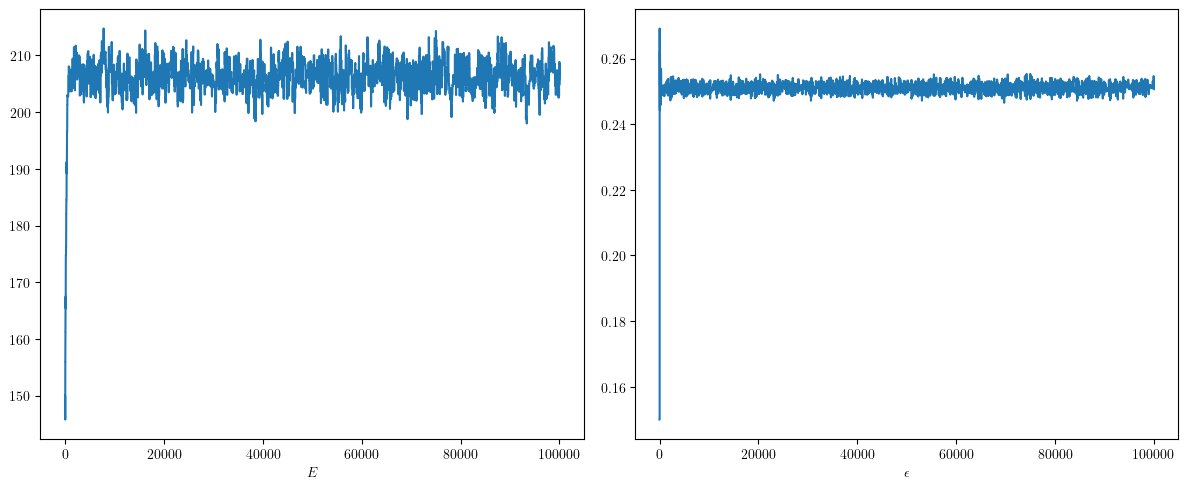

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(samples[:, 0])
ax2.plot(samples[:, 1])
ax1.set_xlabel("$E$")
ax2.set_xlabel("$\epsilon$")
plt.tight_layout()

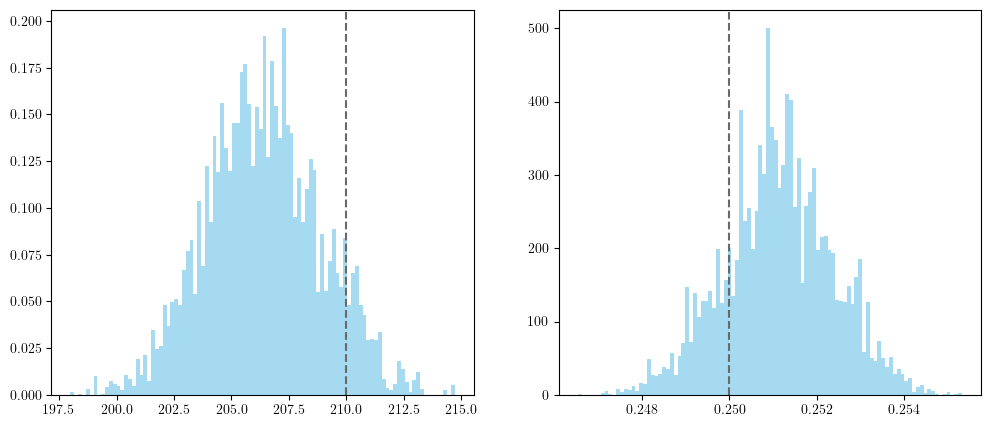

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(samples[1000:, 0], bins=100, density=True, alpha=0.75, color="skyblue")
ax1.axvline(E, ls="--", color="dimgray")

ax2.hist(samples[1000:, 1], bins=100, density=True, alpha=0.75, color="skyblue")
ax2.axvline(stress_y, ls="--", color="dimgray");

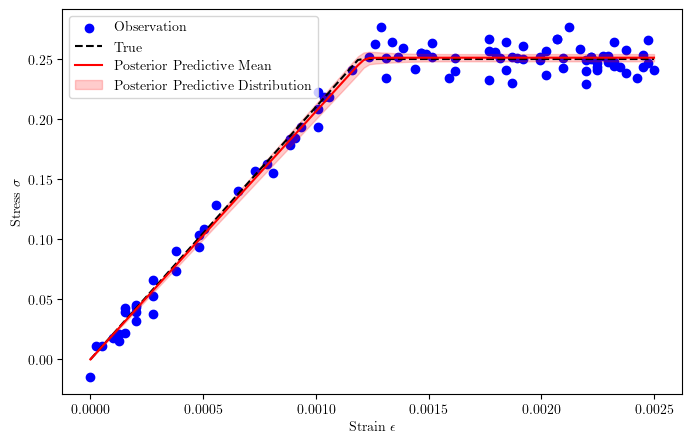

In [20]:
predictions = np.array(
    [compute_stress(sample[0], sample[1], strain) for sample in samples]
)

posterior_predictive_mean = np.mean(predictions, axis=0)
posterior_predictive_std = np.std(predictions, axis=0)

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.scatter(strain_observed, stress_observed, color="blue", label="Observation")
ax1.plot(strain, stress, "k--", label="True")
ax1.plot(
    strain, posterior_predictive_mean, color="red", label="Posterior Predictive Mean"
)
ax1.fill_between(
    strain,
    posterior_predictive_mean - 2 * posterior_predictive_std,
    posterior_predictive_mean + 2 * posterior_predictive_std,
    color="red",
    alpha=0.2,
    label="Posterior Predictive Distribution",
)
ax1.set_xlabel("Strain $\epsilon$")
ax1.set_ylabel("Stress $\sigma$")
ax1.legend()

## 9. Adaptive Metropolis Hastings (`Sampler` and `Proposal` class)

In [21]:
from tqdm import tqdm


class Sampler:

    def __init__(self, posterior, proposal, steps, init):
        self.posterior = posterior
        self.proposal = proposal
        self.steps = int(steps)  # n_samples
        self.init = init
        self.samples = None

    def sample(self):
        """
        Sampling
        """
        self.samples = [self.init.copy()]
        for _ in tqdm(range(self.steps), desc="Sampling"):
            self._sample_step()

    def get_samples(self):
        """
        Returns the samples
        """
        return np.array(self.samples)

    def _sample_step(self):
        """
        Draw a new sample
        """
        point = self.samples[-1]
        proposal = self.proposal.draw(self.samples)
        self.samples.append(self._accept_or_reject(point, proposal))

    def _accept_or_reject(self, x_i, x_p):
        """
        Accept of reject a new candidate

        Parameters
        ----------
        x_i : ndarray
            Current sample

        x_p : ndarray
            New sample (x_p) is proposed by drawing from a proposal
            distribution

        n_accept : int
            Count of accepted samples

        Returns
        -------

        """
        alpha = self._compute_acceptance_ratio(x_i, x_p)
        u = np.random.uniform(low=0.0, high=1.0)
        if u <= alpha:  # Accept proposal
            return x_p
        else:  # Reject proposal
            return x_i

    def _compute_acceptance_ratio(self, x_i, x_p):
        return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))


class MetropolisHastings(Sampler):
    pass

In [22]:
class Proposal:
    """
    Proposal class

    TODO: look at pysampler/proposal.py
    """
    def __init__(self, step_size):
        self.step_size = step_size
        
    def draw(self, samples):
        return np.random.normal(samples[-1], self.step_size)


class GaussianProposal(Proposal):
    pass


class AdaptiveProposal:
    """
    Adaptive proposal class - update the the covariance matrix of the proposal
    distribution using existing knowledge of the posterior

    Haario, H., Saksman, E., and Tamminen, J. (1999). Adaptive proposal
    distribution for random walk metropolis algorithm. Computational
    Statistics, 14(3):375-395. 1, 2

    Attributes
    ----------
    update_freq: int
        Proposal distribution update frequency (default = 1000). The
        frequency at which the proposal distribution is updated.

    n_K : ndarray
        Number of samples / update frequency

    R_0 : ndarray (floats)
        Initial covariance matrix (this can be chosen as the identify matrix
        if you have no prior knowledge)

    R_t : ndarray (floats)
        Updated covariance matrix

    i : int
        Counter to track how many times the proposal has been called

    Notes
    -----
    - TODO: is n_K equal to n_samples?
    - TODO: gamma is missing from the draw method
    """

    def __init__(self, cov, step_size=2.38, update_freq=1000):
        self.cov = cov
        self.step_size = step_size
        self.update_freq = update_freq
        self.R_t = cov
        self.i = 0

    def draw(self, samples):
        """
        Draw x (candidate) from proposal distribution q

        Parameters
        ----------
        x_i : ndarray
            Current sample

        Returns
        -------
        x_p : ndarray
            Proposed sample (candidate sample)

        """
        self.i += 1
        if self.i % self.update_freq == 0:
            self._adapt_cov(samples)
        return np.random.multivariate_normal(samples[-1], self.R_t)

    def _adapt_cov(self, K):
        """
        Parameters
        ----------
        K : ndarray

        Returns
        -------
        R_t : ndarray (floats)
            Updated covariance matrix
        """
        K_tilde = self._compute_K_tilde(K)
        self.R_t = (1 / (len(K) - 1)) * np.matmul(np.transpose(K_tilde), K_tilde)

    def _compute_K_tilde(self, K):
        """
        Calculate the centred matrix

        Parameters
        ----------
        K : ndarray
            Sample chain - all previous samples are stored in matrix K of size
            n_k x n_p, where n_k is... and n_p is the number of unknown
            parameters. Each row represents one sampled point.

        K_mean : ndarray
            History (evolution) of mean value of all previous samples
            (n_samples x n_p)

        Returns
        -------
        K_tilde : ndarray
            The centred matrix n_K x n_p (K_tilde = K - E[K])
        """
        return K - np.mean(K, 0)

In [23]:
proposal = Proposal(np.array([2.5, 0.05]))
mh = Sampler(posterior, proposal, 1e5, np.array([150, 0.15]))
mh.sample()
samples = mh.get_samples()

Sampling:   0%|                                                                                   | 0/100000 [00:00<?, ?it/s]/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_78354/4214639039.py:63: RuntimeWarning: invalid value encountered in scalar divide
  return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))
Sampling:   3%|█▉                                                                    | 2741/100000 [00:00<00:10, 9127.12it/s]/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_78354/4214639039.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))
Sampling: 100%|████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9130.16it/s]


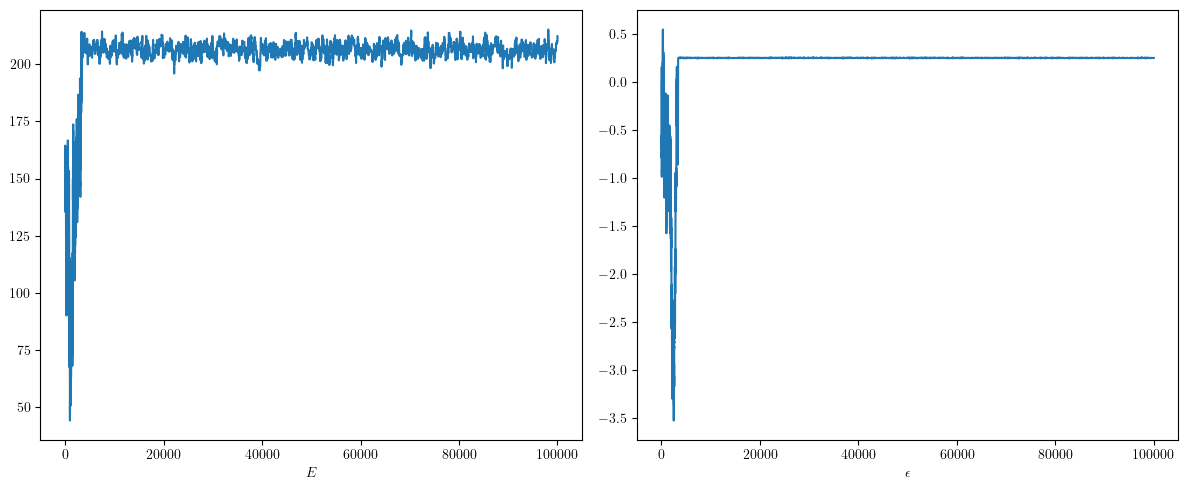

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(samples[:, 0])
ax2.plot(samples[:, 1])
ax1.set_xlabel("$E$")
ax2.set_xlabel("$\epsilon$")
plt.tight_layout()

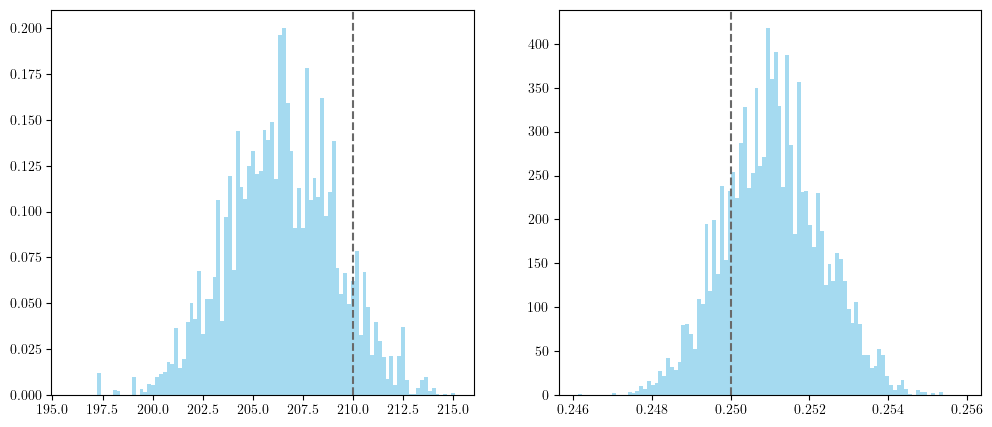

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(samples[10000:, 0], bins=100, density=True, alpha=0.75, color="skyblue")
ax1.axvline(E, ls="--", color="dimgray")
ax2.hist(samples[10000:, 1], bins=100, density=True, alpha=0.75, color="skyblue")
ax2.axvline(stress_y, ls="--", color="dimgray");

In [26]:
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 5e5, np.array([150, 0.15]))
mh.sample()
samples = mh.get_samples()

Sampling:   0%|                                                                                   | 0/500000 [00:00<?, ?it/s]/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_78354/4214639039.py:63: RuntimeWarning: invalid value encountered in scalar divide
  return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))
/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_78354/4214639039.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))
Sampling: 100%|████████████████████████████████████████████████████████████████████| 500000/500000 [01:31<00:00, 5439.18it/s]


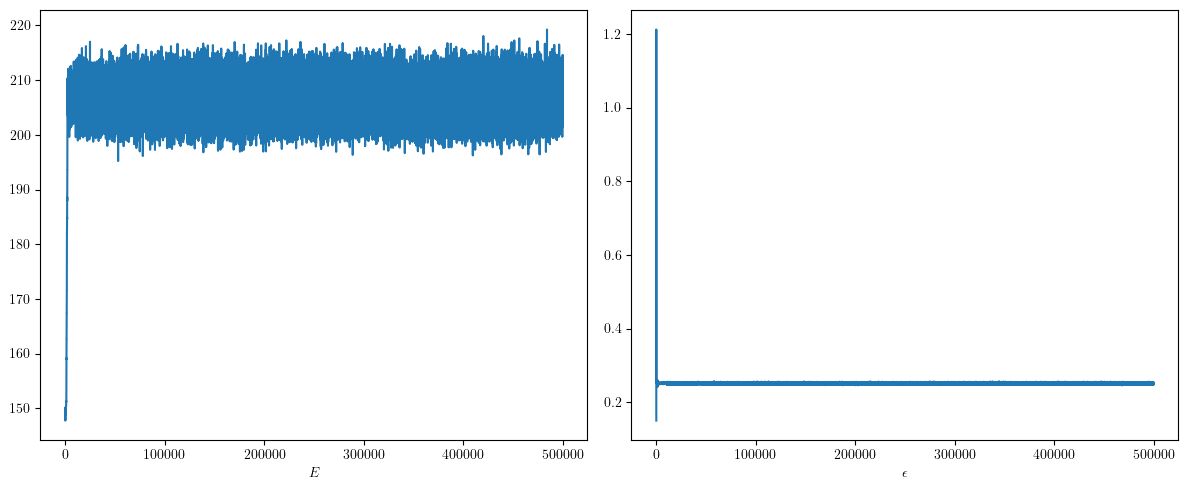

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(samples[:, 0])
ax2.plot(samples[:, 1])
ax1.set_xlabel("$E$")
ax2.set_xlabel("$\epsilon$")
plt.tight_layout()

In [28]:
def scatter_hist(x, y, p, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    ax.scatter(x, y, s=1, c=p)
    
    xbinwidth = (np.max(x) - np.min(x)) / 100
    ybinwidth = (np.max(y) - np.min(y)) / 100
    xbins = np.arange(np.min(x), np.max(x) + xbinwidth, xbinwidth)
    ybins = np.arange(np.min(y), np.max(y) + ybinwidth, ybinwidth)
    ax_histx.hist(x, bins=xbins, density=True, histtype='step')
    ax_histy.hist(y, bins=ybins, density=True, histtype='step', orientation='horizontal')

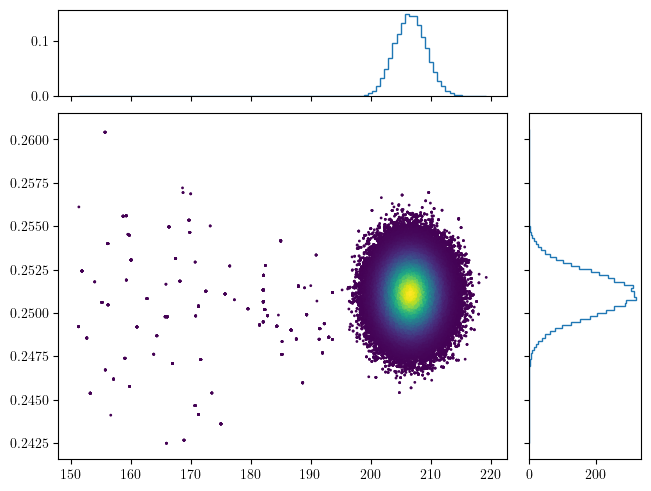

In [29]:
fig = plt.figure(layout='constrained')
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
p = [posterior.evaluate(sample) for sample in samples] # TODO: save this in the Sampler class
scatter_hist(samples[1000:, 0], samples[1000:, 1], p[1000:], ax, ax_histx, ax_histy)

## 9. MCMC convergence

Assessing convergence in Markov Chain Monte Carlo (MCMC) methods is crucial to ensure that the generated samples adequately represent the target distribution. Several methods can be used to assess convergence:

1. **Visual Inspection**: Plotting trace plots for each parameter can give a visual indication of convergence. Trace plots should appear as random walks without clear trends or patterns.

2. **Gelman-Rubin Diagnostic (R-hat)**: This diagnostic compares the variance between multiple chains to the variance within each chain. An R-hat close to 1 indicates convergence. Typically, an R-hat value less than 1.1 is considered acceptable.

3. **Effective Sample Size (ESS)**: ESS estimates the number of independent samples generated by the MCMC chain. It accounts for autocorrelation within the chain. Higher ESS indicates better mixing and convergence.

4. **Autocorrelation**: Autocorrelation measures the correlation between a sample and lagged versions of itself. High autocorrelation indicates poor mixing. Plotting autocorrelation functions can help visualize this.

5. **Geweke Diagnostic**: This diagnostic compares the mean and variance of segments from the beginning and end of a single chain. Large discrepancies suggest lack of convergence.

6. **Convergence Diagnostics Plots**: Various diagnostic plots like density plots, histogram plots, and scatter plots comparing different chains can also be helpful in assessing convergence.

7. **Bayesian p-values**: These are based on the distribution of a discrepancy measure between two halves of the chain. Large p-values suggest convergence.

8. **Energy Plots**: These plots track the energy of the system over iterations. Stable energy levels indicate convergence.

9. **Posterior Predictive Checks (PPCs)**: Simulate new data from the fitted model and compare it to observed data. Poor fit suggests lack of convergence.

10. **Cross-Validation**: Split the data into training and test sets, fit the model on training data, and validate on test data. Consistent predictions indicate convergence.

By employing a combination of these methods, you can effectively assess convergence in MCMC simulations and ensure reliable inference from the sampled distributions.

## 10. Complex posterior distribution

Picture yourself traversing a terrain with numerous peaks and valleys, akin to navigating a complex multi-modal Gaussian distribution. In this analogy, optimisation corresponds to seeking out the highest summit, akin to finding the global maximum, which represents the optimal solution. It focuses on pinpointing the singular best point amidst the landscape, much like identifying the highest peak. Conversely, MCMC mirrors the process of surveying the entire topography, encompassing all peaks and troughs. Instead of solely homing in on the highest point, MCMC explores the full distribution, capturing the intricacies of the landscape. Thus, while optimisation targets the global maximum, MCMC methodically maps out the complete distribution, analogous to exploring the entirety of the terrain.

**Banana:**

Below is a simple implementation of a banana-shaped posterior distribution. This function creates a banana-shaped posterior distribution by combining a quadratic term $(x_2 - x_1^2)^2$ with a Gaussian-like term $(x_1 - 2)^2$, exponentiated to ensure positivity. Adjusting the coefficients and terms can modify the shape and size of the "banana".

In [30]:
def banana(x):
    x1, x2 = x
    return np.exp(-0.1 * ((x2 - x1**2)**2 + (x1 - 2)**2))

In [31]:
def weighted_multi_gaussian_mixture(x):
    x1, x2 = x
    means = [(0, 0), (2, 7), (5, 4)]
    stds = [1.5, 0.5, 1]
    weights = [0.3, 0.8, 0.2]
    return sum(w * np.exp(-((x1 - mean[0])**2 + (x2 - mean[1])**2) / (2 * std**2)) for mean, std, w in zip(means, stds, weights))

In [32]:
class Posterior:

    def __init__(self, distribution):
        self.distribution = distribution
        
    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.distribution(x)

In [33]:
posterior = Posterior(distribution=banana)
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 1e5, np.array([0, 10]))
mh.sample()
samples = mh.get_samples()

Sampling: 100%|███████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 28137.25it/s]


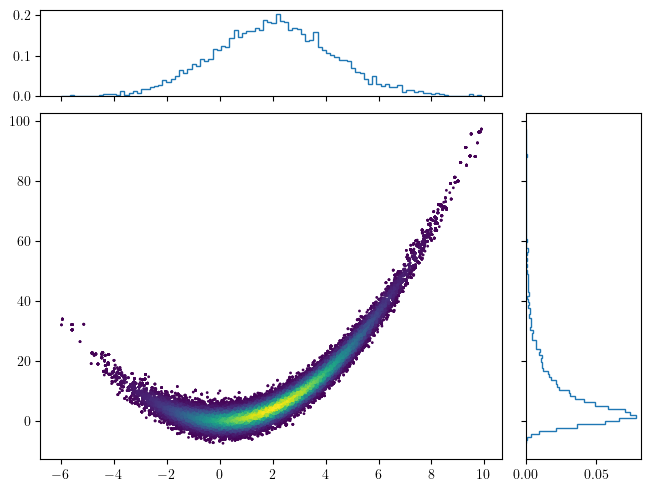

In [34]:
fig = plt.figure(layout='constrained')
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
p = [posterior.evaluate(sample) for sample in samples] # TODO: save this in the Sampler class
scatter_hist(samples[:, 0], samples[:, 1], p, ax, ax_histx, ax_histy)

In [35]:
posterior = Posterior(distribution=weighted_multi_gaussian_mixture)
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 1e5, np.array([0, 10]))
mh.sample()
samples = mh.get_samples()

Sampling: 100%|███████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 24022.59it/s]


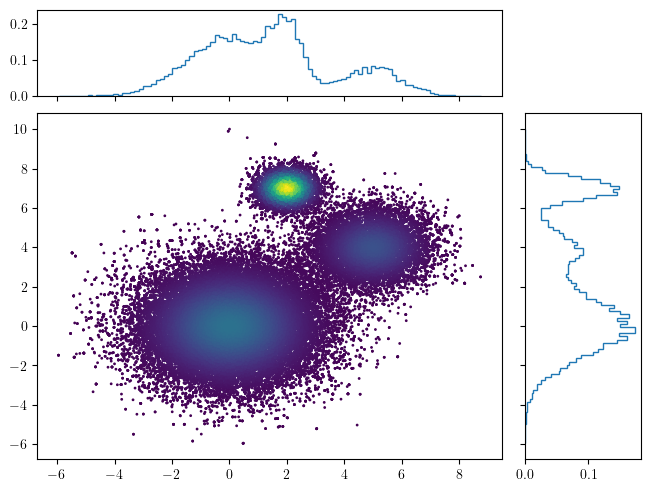

In [36]:
fig = plt.figure(layout='constrained')
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
p = [posterior.evaluate(sample) for sample in samples] # TODO: save this in the Sampler class
scatter_hist(samples[:, 0], samples[:, 1], p, ax, ax_histx, ax_histy)

## Constitutive model and *true* material parameters

It is assumed that the behaviour of the material specimen can be accurately described by a linear elastic-perfectly plastic law that is defined by two parameters: (1) Young's modulus $E$ and (2) yield stress $\sigma_{y0}$.

The stress-strain response of the linear elastic-perfectly plastic model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Where $\textbf{x}$ is the parameter vector:

$$\textbf{x} = [E \; \sigma_{y0}]^T$$

and $E$ is the Young's modulus and $\sigma_{y0}$ is the initial yield stress. Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

The *true* material parameters that we are attempting to identify (infer) are:

$$E = 210 \; \textrm{GPa} \quad \sigma_{y0} = 0.25 \; \textrm{GPa}$$

The *true* stress-strain response is illustrated in the following figure.

In [37]:
E = 210  # Young's modulus (GPa)
stress_y = 0.25  # Yield stress (GPa)
s_noise = 0.01  # Noise in the stress measurement (GPa)

model = LEPP(E, stress_y, s_noise)
strain = np.linspace(0, 2.5e-3, 100)
model.stress_strain_response(strain)

NameError: name 'LEPP' is not defined

## Noisy experimental observations (stress-strain response)

The experimental observations are contaminated by noise. Note that only the stress measurement is contaminated by noise but we will consider an example later where the strain measurement is also contaminated by noise.

The observations are generated numerically so that they deviate from the true constitutive model. The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$. The number of generated observations can be selected by the user. They will note that increasing the number of observations reduces the uncertainty in the estimates of the material parameters.

In [ ]:
strain_data, stress_data = model.generate_synthetic_data(
    strain, 12, seed=12345
)  # seed=54321
plt.scatter(strain_data, stress_data)
add_labels("Noisy experimental observations", "Strain $\epsilon$", "Stress $\sigma$")

## Likelihood $\pi(y|\textbf{x})$

The likelihood function for a single stress measurement is given by the following equation

$$\pi(y|\textbf{x}) = \pi_{noise}(y - \sigma(\epsilon, \textbf{x})) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - \sigma(\epsilon, \textbf{x})\right)^2}{2s^2_{noise}}}\right)$$

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior $\pi(\textbf{x})$

Choosing the prior distribution in the form of a modified normal distribution:

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

The following mean vector (prior candidate vector) and convariance matrix are selected:

$$\overline{\textbf{x}} = \begin{bmatrix} 200 \\ 0.29 \end{bmatrix} \; \text{GPa}, \quad \Gamma_\textbf{x} = \begin{bmatrix} 2500 & 0 \\ 0 & 2.7778 \times 10^{-4} \end{bmatrix} \; \text{GPa}^2$$

In [ ]:
x_prior = np.array([[200], [0.29]])  # Mean vector (GPa)
cov_matrix_prior = np.array([[2500, 0], [0, 2.7778e-4]])  # Covariance matrix (GPa^2)
model.set_priors(x_prior, cov_matrix_prior)

## Posterior $\pi(\textbf{x}|\textbf{y})$

The posterior distribution for a single stress measurement is given by the following equation:

$$\pi(\textbf{x}|y) \propto \pi(\textbf{x})\pi(y|\textbf{x}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

If we now consider the posterior distribution of the previous measurement to be the prior distribution of the current measurement, the posterior for all $n_m$ measurements can be expressed as:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x})) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

Where $n_m$ is the number of measurements, $y_i$ is the measured stress and $\epsilon_i$ is the measured strain.

In [ ]:
x_candidate = np.array([[210], [0.25]])
print(model.posterior(strain_data, stress_data, x_candidate))

x_candidate = np.array([[200], [0.29]])
print(model.posterior(strain_data, stress_data, x_candidate))

## Identification of the material parameters: Metropolis-Hastings method

Determine the PDF for the Young's modulus $E$ and yield stress $\sigma_{y0}$ using the standard Metropolis-Hastings method.

In [ ]:
data = [strain_data, stress_data]
mh = MetropolisHastings(model, data, n_samples=1e5, step_size=np.array([[2.5], [0.05]]))

x_0 = np.array([[200], [0.29]])  # Initial sample
x_hist, pdf_hist, accept_rate = mh.sample(x_0)

The chain is run for 1E5 samples and the first 3000 samples are burnt (i.e. the first 3000 samples are not used to determine the mean, the covariance matrix and the MAP estimate).

In [ ]:
x_mean = mh.calculate_mean(x_hist)
MAP_point = mh.calculate_MAP_point(x_hist, pdf_hist)
print(x_mean, MAP_point)

In [ ]:
x_cov = mh.calculate_covariance(x_hist)
print(x_cov)

### Visualise the proposal distribution

Move to MCMC notebook

In [ ]:
n_samples = 100000
x_i = ([190], [0.2])
x_p = np.zeros([n_samples, np.size(x_i)])

for i in range(n_samples):
    x_p[i, :] = np.transpose(mh.draw_proposal(x_i))

plt.hist(x_p[:, 0], 100);

### Posterior

In [ ]:
# Histogram of the Markov chain values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(x_hist[:, 0], 100)
ax2.hist(x_hist[:, 1], 100)
ax1.axvline(E, ls="--", color="dimgray")
ax2.axvline(stress_y, ls="--", color="dimgray")

In [ ]:
# Density plot of the Markov chain values - use kernel density estimation or marginal distribution? Look at Seaborn?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(x_hist[:, 0], pdf_hist)
ax2.scatter(x_hist[:, 1], pdf_hist)
ax1.axvline(E, ls="--", color="dimgray")
ax2.axvline(stress_y, ls="--", color="dimgray")

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(x_hist[:, 0], x_hist[:, 1], s=10, c=pdf_hist, marker="o", cmap=cm.jet)
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
plt.axvline(E, ls="--", color="dimgray")
plt.axhline(stress_y, ls="--", color="dimgray")

if save_figures:
    fig.savefig("LEPP_posterior.png", dpi=300)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    x_hist[:, 0], x_hist[:, 1], pdf_hist, s=10, c=pdf_hist, marker="o", cmap=cm.jet
)
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
ax.set_zlabel("Probability density");

In [ ]:
# model.calculate_PPD(strain, x_hist)

### Convergence

A commonly employed approach to check the stability and convergence of the scheme is to trace the generated samples and analyse their characteristics.

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7.5, 7.5))
ax1.plot(x_hist[:, 0])
ax1.axhline(E, ls="--", color="dimgray")
ax2.plot(x_hist[:, 1])
ax2.axhline(stress_y, ls="--", color="dimgray")

### Acceptance rate

It has been shown that optimal acceptance rate is approximately 0.25 [[1]](https://arxiv.org/pdf/1504.01896.pdf). If the acceptance rate is too high or too low it will slow down the convergence of the Markov chain.

In [ ]:
plt.plot(accept_rate)

## Identification of the material parameters: Adaptive Metropolis-Hastings method

In [ ]:
data = [strain_data, stress_data]
mh_ap = AdaptiveMetropolisHastings(model, data, n_samples=2e5)

x_0 = np.array([[200], [0.29]])  # Initial sample
x_hist, pdf_hist, accept_rate = mh_ap.sample(x_0)

### Posterior

In [ ]:
# Density plot of the Markov chain values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(x_hist[:, 0], pdf_hist)
ax2.scatter(x_hist[:, 1], pdf_hist)
ax1.axvline(E, ls="--", color="dimgray")
ax2.axvline(stress_y, ls="--", color="dimgray")

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(x_hist[:, 0], x_hist[:, 1], s=10, c=pdf_hist, marker="o", cmap=cm.jet)
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
plt.axvline(E, ls="--", color="dimgray")
plt.axhline(stress_y, ls="--", color="dimgray")

if save_figures:
    fig.savefig("LEPP_posterior_adaptive.png", dpi=300)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    x_hist[:, 0], x_hist[:, 1], pdf_hist, s=10, c=pdf_hist, marker="o", cmap=cm.jet
)
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")
ax.set_zlabel("Probability density");

### Convergence

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7.5, 7.5))
ax1.plot(x_hist[:, 0])
ax1.axhline(E, ls="--", color="dimgray")
ax2.plot(x_hist[:, 1])
ax2.axhline(stress_y, ls="--", color="dimgray")

In [ ]:
plt.plot(accept_rate)

## Posterior Predictive Distribution (PPD)

[Posterior Predictive Distributions in Bayesian statistics](https://www.physicsforums.com/insights/posterior-predictive-distributions-in-bayesian-statistics/)

The posterior predictive distribution is the distribution of possible unobserved values conditional on the observed values.

$$\pi(y^{\textrm{new}}|\textbf{y}, \boldsymbol{\epsilon}, \epsilon^{\textrm{new}}) = \int_{\mathbb{R}^{n_p}} \pi(y^{\textrm{new}}|\textbf{x}, \epsilon^{\textrm{new}}) \pi(\textbf{x}|\textbf{y}, \boldsymbol{\epsilon}) dx$$


Note that $\pi(\textbf{x}|\textbf{y}, \boldsymbol{\epsilon})$ has already been computed. The $i^{th}$ sample is replaced in $\pi(y^{\textrm{new}}|\textbf{x}_i, \epsilon^{\textrm{new}})$, which is subsequently used to generate a sample for new measurement $y_i^{new}$.

### Prediction bounds

The below figure illustrates the stress-strain response using parameters drawn from the **95% credible region** of the posterior as well as the posterior predictions. The 95% credible region is the region that contains 95% of the posterior.

The **95% prediction interval** is obtained using the posterior predictive distribution and its upper and lower bounds read:

$$\textrm{prediction bounds} = \overline{\textrm{PPD}} \pm 2S_{\textrm{PDD}}$$

where $\overline{\textrm{PPD}}$ denotes the mean of posterior predictive distributions for the new measurement (i.e. $y_{\textrm{new}}$ in Eq. (59)) and $s_{\textrm{PDD}}$ denotes its standard deviation.
